In [149]:
import numpy as np
import pandas as pd
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
import json
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

### Loading the dinesafe data

In [3]:
datapath = r'../data/'

In [4]:
dfd = pd.read_csv(datapath + 'dinesafe.csv', parse_dates=['INSPECTION_DATE']).drop('Unnamed: 0', axis=1)
dfd.head()

,ROW_ID,ESTABLISHMENT_ID,INSPECTION_ID,ESTABLISHMENT_NAME,ESTABLISHMENTTYPE,ESTABLISHMENT_ADDRESS,LATITUDE,LONGITUDE,ESTABLISHMENT_STATUS,MINIMUM_INSPECTIONS_PERYEAR,INFRACTION_DETAILS,INSPECTION_DATE,SEVERITY,ACTION,COURT_OUTCOME,AMOUNT_FINED
0,1,1222579,103868579,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Operator fail to properly wash equipment,2016-12-21,M - Minor,Notice to Comply,,
1,2,1222579,104063869,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,NaN,2017-10-04,NaN,NaN,NaN,NaN
2,3,1222579,104246429,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Fail to Hold a Valid Food Handler's Certificat...,2018-06-20,NA - Not Applicable,Notice to Comply,,
3,4,1222579,104246429,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Operator fail to properly wash equipment,2018-06-20,M - Minor,Notice to Comply,,
4,5,1222579,104246429,SAI-LILA KHAMAN DHOKLA HOUSE,Food Take Out,870 MARKHAM RD,43.76798,-79.229029,Pass,2,Operator fail to properly wash surfaces in rooms,2018-06-20,M - Minor,Notice to Comply,,


### Initial exploration

In [5]:
# Pass count
df_pass = dfd[['ESTABLISHMENT_STATUS', 'ROW_ID']].groupby('ESTABLISHMENT_STATUS').count()
df_pass['pct'] = df_pass['ROW_ID'] / df_pass['ROW_ID'].sum()
df_pass

,ROW_ID,pct
ESTABLISHMENT_STATUS,,
Closed,352,0.003889
Conditional Pass,17237,0.190422
Pass,72931,0.805689


min date: 2016-09-23
max date: 2018-09-21


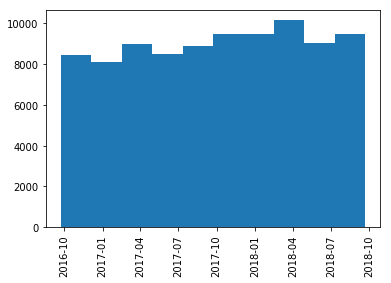

In [6]:
# time
plt.hist(dfd['INSPECTION_DATE'], bins=10)
plt.xticks(rotation='vertical')
print("min date: %s" % dfd['INSPECTION_DATE'].min().date())
print("max date: %s" % dfd['INSPECTION_DATE'].max().date())
plt.show()

In [7]:
# severity
df_severe = dfd[['SEVERITY', 'ROW_ID']].groupby('SEVERITY').count()
df_severe['pct'] = df_severe['ROW_ID'] / df_severe['ROW_ID'].sum()
df_severe

,ROW_ID,pct
SEVERITY,,
C - Crucial,2400,0.038899
M - Minor,32280,0.523194
NA - Not Applicable,4048,0.065610
S - Significant,22970,0.372297


### Fines

In [31]:
df_fined = dfd[(pd.notnull(dfd['AMOUNT_FINED'])) & (dfd['AMOUNT_FINED'] != ' ')].copy()
df_fined['COURT_OUTCOME'].unique()

array(['Conviction - Fined',
       'Conviction - Fined & Order to Close by Court',
       'Charges Withdrawn', 'Conviction - Suspended Sentence',
       'Charges Quashed'], dtype=object)

In [34]:
fine_map = {
    'Conviction - Fined': True,
    'Conviction - Fined & Order to Close by Court': True,
    'Charges Withdrawn': False, 
    'Conviction - Suspended Sentence': True,
    'Charges Quashed': False
}

In [35]:
df_fined['Convicted'] = df_fined['COURT_OUTCOME'].apply(lambda x: fine_map[x])
df_fined['dollar_amt'] = df_fined['AMOUNT_FINED'].apply(lambda x: float(x))

In [36]:
df_fined.head()

,ROW_ID,ESTABLISHMENT_ID,INSPECTION_ID,ESTABLISHMENT_NAME,ESTABLISHMENTTYPE,ESTABLISHMENT_ADDRESS,LATITUDE,LONGITUDE,ESTABLISHMENT_STATUS,MINIMUM_INSPECTIONS_PERYEAR,INFRACTION_DETAILS,INSPECTION_DATE,SEVERITY,ACTION,COURT_OUTCOME,AMOUNT_FINED,Convicted,dollar_amt
695,696,9001150,103920617,STARBUCKS,Restaurant,1088 YONGE ST,43.677997,-79.390257,Pass,1,Operate food premise - fail to keep facility s...,2017-02-28,M - Minor,Ticket,Conviction - Fined,65.00,True,65.0
853,854,9001425,104105703,BERNARD'S PILIPINO SPECIALTIES,Food Take Out,1534 QUEEN ST W,43.640060,-79.439330,Conditional Pass,3,Fail to Hold a Valid Food Handler's Certificat...,2017-12-01,NA - Not Applicable,Ticket,Conviction - Fined,63.50,True,63.5
854,855,9001425,104105703,BERNARD'S PILIPINO SPECIALTIES,Food Take Out,1534 QUEEN ST W,43.640060,-79.439330,Conditional Pass,3,Operate food premise - fail to keep facility s...,2017-12-01,M - Minor,Ticket,Conviction - Fined,63.50,True,63.5
855,856,9001425,104105703,BERNARD'S PILIPINO SPECIALTIES,Food Take Out,1534 QUEEN ST W,43.640060,-79.439330,Conditional Pass,3,Operator fail to ensure room kept free from ma...,2017-12-01,M - Minor,Ticket,Conviction - Fined,63.50,True,63.5
858,859,9001425,104105703,BERNARD'S PILIPINO SPECIALTIES,Food Take Out,1534 QUEEN ST W,43.640060,-79.439330,Conditional Pass,3,Store hazardous foods at internal temperature ...,2017-12-01,C - Crucial,Summons,Conviction - Fined,1130,True,1130.0


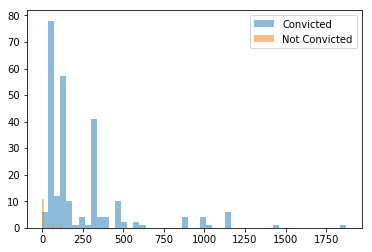

In [42]:
# any fines?
plt.hist(df_fined[df_fined['Convicted']]['dollar_amt'], alpha=0.5, label='Convicted', bins=50)
plt.hist(df_fined[~df_fined['Convicted']]['dollar_amt'], alpha=0.5, label='Not Convicted')
plt.legend()
plt.show()

### Narrowing the Yelp Dataset

In [45]:
f = open(datapath + 'yelp_academic_dataset_business.json', 'r')

buslist = []
for i, line in enumerate(f):
    buslist.append(json.loads(line))
    
dfy = pd.DataFrame(buslist).set_index(['business_id'])

In [46]:
dfy.shape

(188593, 14)

In [74]:
toronto_cities = [x for x in dfy['city'].unique() if 'toronto' in x.lower()] \
                    + [x for x in dfy['city'].unique() if 'etobi' in x.lower()] \
                    + [x for x in dfy['city'].unique() if 'miss' in x.lower()] \
                    + [x for x in dfy['city'].unique() if 'york' in x.lower()] \
                    + [x for x in dfy['city'].unique() if 'etobi' in x.lower()] \
                    + [x for x in dfy['city'].unique() if 'scar' in x.lower()]
toronto_cities

['Toronto',
 'toronto',
 'Downtown Toronto',
 'Toronto Division',
 'Toronto-North York',
 'West Toronto',
 'Toronto-West',
 'North Toronto',
 'Toronto-Etobicoke',
 'Toronto Scarborough',
 'Etobicoke',
 'Etobiicoke',
 'etobicoke',
 'Etobicoke,',
 'Etobicoke On',
 'Toronto-Etobicoke',
 'Mississauga',
 'East Mississauga',
 'Missisauga',
 'Mississauaga',
 'Mississauge',
 'Mississuaga',
 'North York',
 'East York',
 'York',
 'North  York',
 'NORTH YORK',
 'Yorkdale',
 'NorthYork',
 'Toronto-North York',
 'York Regional Municipality',
 'Regional Municipality of York',
 'Etobicoke',
 'Etobiicoke',
 'etobicoke',
 'Etobicoke,',
 'Etobicoke On',
 'Toronto-Etobicoke',
 'Scarborough',
 'Scarbrough',
 'SCARBOROUGH',
 'Scarborough,',
 'Scarobrough',
 'Scarborough (C)',
 'Toronto Scarborough']

In [76]:
df_toronto = dfy[(dfy['city'].isin(toronto_cities)) & (dfy['state'] == 'ON')].copy()
df_toronto.shape

(24453, 14)

In [77]:
df_toronto['postal_prefix'] = df_toronto['postal_code'].apply(lambda x: x[:2])
df_toronto['postal_prefix'].unique()

array(['M6', 'L4', 'M5', 'L5', 'M1', 'M3', 'M8', 'M4', 'M2', 'M9', 'M7',
       '', 'V0', 'L3', 'L1', 'L6', 'P0', 'W8', 'K0', 'V5'], dtype=object)

In [92]:
len(df_toronto['categories'].unique())
# how do we pick out the categories that are relevant?

12651

In [93]:
[x for x in df_toronto['categories'].dropna().unique() if 'burger' in x.lower()]

['American (Traditional), Burgers, Fast Food, Restaurants',
 'Restaurants, Burgers',
 'Restaurants, Food Delivery Services, Food, Burgers, Chicken Wings',
 'Food, Burgers, Ice Cream & Frozen Yogurt, Restaurants',
 'Burgers, Fast Food, Restaurants, Hot Dogs',
 'Fast Food, Hot Dogs, Burgers, Restaurants',
 'Fast Food, Restaurants, Burgers',
 'Burgers, Chicken Wings, Restaurants, Canadian (New)',
 'Burgers, Poutineries, Fast Food, Canadian (New), Restaurants',
 'Restaurants, Vietnamese, Asian Fusion, Burgers',
 'American (Traditional), Fast Food, Restaurants, Burgers',
 'Burgers, Restaurants',
 'Burgers, Fast Food, Restaurants',
 'Bars, Canadian (New), Nightlife, Fast Food, Pubs, Fish & Chips, Food, Seafood, American (Traditional), Restaurants, Burgers',
 'Nightlife, Bars, Cafes, Sandwiches, Restaurants, Venues & Event Spaces, Breakfast & Brunch, Burgers, Event Planning & Services',
 'Burgers, Breakfast & Brunch, Fast Food, Restaurants',
 'Burgers, Restaurants, Fast Food',
 'Vegetarian, B

In [98]:
keywords = [
    'food',
    'restaurant',
    'bar',
    'soup',
    'sushi',
    'seafood',
    'cafe',
    'diner',
    'steak',
    'burger'
]

# build large list of lists
all_list = []
for kw in keywords:
    all_list.append([x for x in df_toronto['categories'].dropna().unique() if kw in x.lower()])

# merge list of lists
master_list = []
for sublist in all_list:
    for item in sublist:
        if item not in master_list:
            master_list.append(item)
len(master_list)

6879

In [105]:
dft = df_toronto[df_toronto['categories'].isin(master_list)].copy()
dft.head()

,address,attributes,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state,postal_prefix
business_id,,,,,,,,,,,,,,,
9A2quhZLyWk0akUetBd8hQ,631 Bloor St W,"{'BusinessParking': '{'garage': False, 'street...","Food, Bakeries",Toronto,None,0,43.664378,-79.414424,Bnc Cake House,Koreatown,M6G 1K8,7,4.0,ON,M6
6OuOZAok8ikONMS_T3EzXg,"3417 Derry Road E, Unit 103","{'Alcohol': 'none', 'BusinessAcceptsCreditCard...","Restaurants, Thai",Mississauga,None,1,43.712946,-79.632763,Thai One On,Ridgewood,L4T 1A8,7,2.0,ON,L4
tZnSodhPwNr4bzrwJ1CSbw,595 Markham Street,"{'Alcohol': 'full_bar', 'Ambience': '{'romanti...","Cajun/Creole, Southern, Restaurants",Toronto,"{'Tuesday': '17:0-1:0', 'Wednesday': '17:0-1:0...",0,43.664125,-79.411886,Southern Accent Restaurant,Palmerston,M6G 2L7,146,4.0,ON,M6
5J3b7j3Fzo9ISjChmoUoUA,746 Street Clair Avenue W,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Food, Bakeries, Coffee & Tea",Toronto,"{'Monday': '7:30-19:0', 'Tuesday': '7:30-19:0'...",1,43.681328,-79.427884,Mabel's Bakery,Wychwood,M6C 1B5,23,4.0,ON,M6
PMDlKLd0Mxj0ngCpuUmE5Q,99 Yorkville Avenue,"{'Ambience': '{'romantic': False, 'intimate': ...","Restaurants, Food, Canadian (New), Coffee & Tea",Toronto,None,0,43.670885,-79.392379,The Coffee Mill Restaurant,Yorkville,M5R 3K5,25,3.5,ON,M5


### Joining

In [ ]:
dfd = dfd.set_index('ROW_ID')

In [142]:
# converting all to lower case
dfd['name'] = dfd['ESTABLISHMENT_NAME'].apply(lambda x: x.lower())
dfd['address'] = dfd['ESTABLISHMENT_ADDRESS'].apply(lambda x: x.lower())
dft['name'] = dft['name'].apply(lambda x: x.lower())
dft['address'] = dft['address'].apply(lambda x: x.lower())

display(dfd[:1][['name', 'address']])
print(dfd.shape)

display(dft[:1][['name', 'address']])
print(dft.shape)

,name,address
ROW_ID,,
1,sai-lila khaman dhokla house,870 markham rd


(90520, 19)


,name,address
business_id,,
9A2quhZLyWk0akUetBd8hQ,bnc cake house,631 bloor st w


(13760, 15)


In [153]:
dfd.columns

Index(['ESTABLISHMENT_ID', 'INSPECTION_ID', 'ESTABLISHMENT_NAME',
       'ESTABLISHMENTTYPE', 'ESTABLISHMENT_ADDRESS', 'LATITUDE', 'LONGITUDE',
       'ESTABLISHMENT_STATUS', 'MINIMUM_INSPECTIONS_PERYEAR',
       'INFRACTION_DETAILS', 'INSPECTION_DATE', 'SEVERITY', 'ACTION',
       'COURT_OUTCOME', 'AMOUNT_FINED', 'name', 'address', 'match1',
       'add_match1'],
      dtype='object')

In [172]:
# required combined address and name match score
CUT_OFF_SCORE = 0.8

total_count = dft.shape[0]
final_mapper = {}
for i, row in enumerate(dft.iterrows()):
    cur_bus_id = row[0]
    cur_name = row[1]['name']
    cur_addr = row[1]['address']
    print("processing (%s/%s) business: %s at address: %s with id: %s" % (i+1
                                                                          , total_count
                                                                          , cur_name
                                                                          , cur_addr
                                                                          , cur_bus_id))
    
    dfd['match_name'] = dfd['name'].apply(lambda x: fuzz.partial_ratio(x, cur_name))
    dfd['match_addr'] = dfd['address'].apply(lambda x: fuzz.partial_ratio(x, cur_addr))
    dfd['score'] = (dfd['match_name'] /  100) * (dfd['match_addr'] / 100)
    dfd = dfd.sort_values('score', ascending=False)
    if dfd['score'].values[0] > CUT_OFF_SCORE:
        print("\n!!! Found Match for \n(%s, %s) in the dinesafe db \n at (ROW_ID: %s, %s, %s)" % (cur_name
                                                                                       , cur_addr
                                                                                       , dfd.index[0]
                                                                                       , dfd['name'].values[0]
                                                                                       , dfd['address'].values[0]))
        final_mapper[cur_bus_id] = dfd.index[0]
    
    if i > 1000:
        break
    

processing (1/13760) business: bnc cake house at address: 631 bloor st w with id: 9A2quhZLyWk0akUetBd8hQ
processing (2/13760) business: thai one on at address: 3417 derry road e, unit 103 with id: 6OuOZAok8ikONMS_T3EzXg
processing (3/13760) business: southern accent restaurant at address: 595 markham street with id: tZnSodhPwNr4bzrwJ1CSbw
processing (4/13760) business: mabel's bakery at address: 746 street clair avenue w with id: 5J3b7j3Fzo9ISjChmoUoUA
processing (5/13760) business: the coffee mill restaurant at address: 99 yorkville avenue with id: PMDlKLd0Mxj0ngCpuUmE5Q
processing (6/13760) business: la rosa chilena at address: 788 wilson avenue with id: Be7Mwq06nf1eNLblo1ekow

!!! Found Match for 
(la rosa chilena, 788 wilson avenue) in the dinesafe db 
 at (ROW_ID: 5325, la rosa chilena bakery, 788 wilson ave )
processing (7/13760) business: allwyn's bakery at address: 81 underhill drive with id: YIez_A3WOt9J2SXN7OMa2Q

!!! Found Match for 
(allwyn's bakery, 81 underhill drive) in 

processing (48/13760) business: the croissant tree at address: 625 church street with id: webM3oChwDCkzZEmjrSeHQ

!!! Found Match for 
(the croissant tree, 625 church street) in the dinesafe db 
 at (ROW_ID: 17756, the croissant tree, 625 church st )
processing (49/13760) business: garden deli at address: 4141 yonge street with id: mhcaplFScvQBEk50cmd3jg

!!! Found Match for 
(garden deli, 4141 yonge street) in the dinesafe db 
 at (ROW_ID: 82681, garden deli, 4141 yonge st )
processing (50/13760) business: godiva chocolatier at address: 3401 dufferin street with id: uO0isEg1fCvL0BqfDRbVjA
processing (51/13760) business: fox and fiddle yorkmills at address: 865 york mills road with id: cA5DOLBmD_XoNmgj7e3caA
processing (52/13760) business: furama cake & dessert garden at address: 100 king st w with id: _fe36eepp9tsP5vzvKbdQA

!!! Found Match for 
(furama cake & dessert garden, 100 king st w) in the dinesafe db 
 at (ROW_ID: 3583, furama, 100 king st w)
processing (53/13760) business: m


!!! Found Match for 
(the wally tap & grill, 302 o'connor drive) in the dinesafe db 
 at (ROW_ID: 19491, the wally tap and grill, 302 o'connor dr )
processing (97/13760) business: my pho at address: 660 eglinton avenue w with id: 5Xyqd_NxuHN3Wx7r-1RiBw
processing (98/13760) business: debu's indian cuisine at address: 291 augusta ave with id: 14m4FbWr2BIgrbSdPBKG8Q
processing (99/13760) business: novecento at address: 1228 saint clair avenue w with id: 6a7zecn8W8r9dDWwQVb6aA
processing (100/13760) business: kin-kin bubble tea company at address: 1571 sandhurst circle with id: m0ONN_-2wq-xN9clbhoSKQ

!!! Found Match for 
(kin-kin bubble tea company, 1571 sandhurst circle) in the dinesafe db 
 at (ROW_ID: 49357, kin kin bubble tea co., 1571 sandhurst crcl )
processing (101/13760) business: peppers at address: 3027 islington avenue with id: u28SYjn6swe7A2DWdgZ7NQ

!!! Found Match for 
(peppers, 3027 islington avenue) in the dinesafe db 
 at (ROW_ID: 53595, peppers caribbean restaurant, 30

processing (144/13760) business: ital florist at address: 130 westmore drive with id: NBXPDU6VBgg54BEr7s8WWQ
processing (145/13760) business: lindt & sprungli canada at address: 181 university ave with id: gULK714e4SMqag-FHLDLNw
processing (146/13760) business: makimono at address: 634 dixon road with id: Lyzr1uckXL0U-iBoMc0yfg

!!! Found Match for 
(makimono, 634 dixon road) in the dinesafe db 
 at (ROW_ID: 73443, makimono sushi bar & restaurant, 634 dixon rd )
processing (147/13760) business: green mango at address: 2180 bloor st w with id: _yGc7ca7SxPKMG6VjMVAbg
processing (148/13760) business: kobe at address: 2911 derry road e with id: -mQpuiMYGVYUUXd-gbKsYA
processing (149/13760) business: branca at address: 1727 dundas street w with id: OFbiUooV4CqLjrvdOBXz-A

!!! Found Match for 
(branca, 1727 dundas street w) in the dinesafe db 
 at (ROW_ID: 55512, branca, 1727 dundas st w)
processing (150/13760) business: quik chik at address: 801 matheson boulvard w, unit 16 with id: swQkNTX

processing (190/13760) business: haven espresso bar at address: 615a brock avenue with id: pPO_UXvffah1uKhMlo9LBw

!!! Found Match for 
(haven espresso bar, 615a brock avenue) in the dinesafe db 
 at (ROW_ID: 89528, haven espresso, 615 brock ave )
processing (191/13760) business: kinka izakaya bloor at address: 559 bloor st w with id: CN5nuUQod0f8g3oh99qq0w

!!! Found Match for 
(kinka izakaya bloor, 559 bloor st w) in the dinesafe db 
 at (ROW_ID: 74487, kinka izakaya bloor, 559 bloor st w)
processing (192/13760) business: sushi in sushi at address: 2310 battleford road with id: -FyvAo_bNe6eXWpEHpSUrQ
processing (193/13760) business: mr. nonno barber shop at address: 609 bloor street w with id: 36SbEb0QZp_qdmTH81qQDQ
processing (194/13760) business: starbucks at address: 3300 bloor street w with id: 0rg8sJGPWebnxNFExpNdHA

!!! Found Match for 
(starbucks, 3300 bloor street w) in the dinesafe db 
 at (ROW_ID: 69942, starbucks coffee, 3300 bloor st w)
processing (195/13760) business: ca

processing (241/13760) business: pour boy at address: 583 college street with id: 8ZpXbFWIY4uEnmOJMr6gyQ

!!! Found Match for 
(pour boy, 583 college street) in the dinesafe db 
 at (ROW_ID: 59369, pour boy, 583 college st )
processing (242/13760) business: spot coffee at address: 333 bremner boulevard with id: AhRd1MUgnXhCQTTIu3Z2SQ
processing (243/13760) business: blue goose tavern at address: 1 blue goose street with id: 1Ta487VlU6ceB0euIS9-EA

!!! Found Match for 
(blue goose tavern, 1 blue goose street) in the dinesafe db 
 at (ROW_ID: 16774, the blue goose tavern, 1 blue goose st )
processing (244/13760) business: brick house pizza co. at address: 111 queen street s with id: UCnPW3drq6wzO7ovAfxqEA
processing (245/13760) business: sport nutrition depot at address: 632 yonge street with id: aep2Dc7tdI1IVUGaVRjRJQ
processing (246/13760) business: second cup at address: 415 spadina road with id: xkoQ1c4c6F9Fy3J73kN7Rg

!!! Found Match for 
(second cup, 415 spadina road) in the dinesa

processing (288/13760) business: rice & noodle at address: 1508 queen st w with id: Mv3pO01Alty1pXQwi-Uy5A
processing (289/13760) business: burrito bandidos at address: 120 peter st with id: vMqUZEaqALd6Q9b4lO-62g
processing (290/13760) business: panera bread at address: 2575 eglinton avenue w with id: vaImqMx2YCw7ZTMzl1hxSw
processing (291/13760) business: sandoozles smokehouse & pub at address: 709 mount pleasant road with id: fo_w5L2x00wS4NMHzE8oyg
processing (292/13760) business: port union fish & chips at address: 65 rylander boulevard with id: YxgY6tVOpXSoV-1LXlGtBQ
processing (293/13760) business: food cabbie at address:  with id: 8IqVdS0q-JpzZc1-it4lRg
processing (294/13760) business: the fresh tea shop at address: 2300 yonge street, unit pl4 with id: E0djzqBHz923hwj-MJFO6Q

!!! Found Match for 
(the fresh tea shop, 2300 yonge street, unit pl4) in the dinesafe db 
 at (ROW_ID: 77242, the fresh tea shop, 2300 yonge st )
processing (295/13760) business: tosto quickfire pizza past


!!! Found Match for 
(t&t supermarket, 222 cherry street) in the dinesafe db 
 at (ROW_ID: 24831, t & t supermarket, 222 cherry st )
processing (331/13760) business: momo place at address: 529 evans avenue with id: pKQCOpvY6s0b8Bg8KqZ3zg
processing (332/13760) business: ho su bistro at address: 254 queen st w with id: QTSCFDPcuROE8UCvGS8Fiw
processing (333/13760) business: tim hortons at address: 73 front st e with id: hsgtedqml9ZDB2cbTZe_mA

!!! Found Match for 
(tim hortons, 73 front st e) in the dinesafe db 
 at (ROW_ID: 61121, tim hortons, 55 front st e)
processing (334/13760) business: sushi 101 at address: 513 bloor st w with id: h5TdULM3nc6IoqY4yOdZqg
processing (335/13760) business: mildred's temple kitchen at address: 85 hanna avenue with id: kOFDVcnj-8fd3doIpCQ06A

!!! Found Match for 
(mildred's temple kitchen, 85 hanna avenue) in the dinesafe db 
 at (ROW_ID: 27156, mildred's temple kitchen, 85 hanna ave )
processing (336/13760) business: my pho at address: 660 eglinton av


!!! Found Match for 
(thai shan inn, 2404 dufferin street) in the dinesafe db 
 at (ROW_ID: 54082, thai shan inn restaurant, 2404 dufferin st )
processing (377/13760) business: organic oven bakery and cafe at address: 3189 yonge street with id: kCmUTthR2Z7O7wtUqZGXug
processing (378/13760) business: hi! there at address: 599 bloor street w with id: 8qsZdSaHko5D6HfG4rPNUw
processing (379/13760) business: kung fu tea at address: 264 spadina avenue with id: H2gXfJQXltAqnpEwc58Img

!!! Found Match for 
(kung fu tea, 264 spadina avenue) in the dinesafe db 
 at (ROW_ID: 80458, kung fu tea, 264 spadina ave )
processing (380/13760) business: cafe supreme at address: 222 bay street with id: _YzvyyudPRtIZkWE1Jmt_g
processing (381/13760) business: le papillon park at address: 1001 eastern ave with id: aervNtqzrKf0CGrFo4xfKw
processing (382/13760) business: arepa café at address: 490 queen street w with id: ftvZ6BVmbZndKcVPEdakIQ
processing (383/13760) business: los cafetaleros at address: 774 co

processing (423/13760) business: hitch at address: 1216 queen street e with id: dHI6YDCDuU5X9tS-3y0Bcg

!!! Found Match for 
(hitch, 1216 queen street e) in the dinesafe db 
 at (ROW_ID: 45182, hitch, 1216 queen st e)
processing (424/13760) business: starbucks at address: 1564 royal york road with id: bD5sbDj_lMYnyUpbG3xm3Q

!!! Found Match for 
(starbucks, 1564 royal york road) in the dinesafe db 
 at (ROW_ID: 56994, starbucks coffee, 1564 royal york rd )
processing (425/13760) business: nunu ethiopian fusion at address: 1178 queen street w with id: xfbjRpE3yhRQ9Zw-D_mBgQ

!!! Found Match for 
(nunu ethiopian fusion, 1178 queen street w) in the dinesafe db 
 at (ROW_ID: 30263, nunu, 1178 queen st w)
processing (426/13760) business: number one at address: 897 pape avenue with id: CyQXHdumQvxKAkXglORTdQ

!!! Found Match for 
(number one, 897 pape avenue) in the dinesafe db 
 at (ROW_ID: 46839, number one chinese restaurant, 897 pape ave )
processing (427/13760) business: el nahual at ad

processing (469/13760) business: panago pizza at address: 104 - 120 lynn williams street with id: fS3nh8egPi7eIBZi3Y3W7w

!!! Found Match for 
(panago pizza, 104 - 120 lynn williams street) in the dinesafe db 
 at (ROW_ID: 64949, panago, 120 lynn williams st )
processing (470/13760) business: schmaltz appetizing at address: 414 dupont street with id: A-QlS6_vpJI_Yi67AyNJLw
processing (471/13760) business: le petit déjeuner at address: 191 king street e with id: DizSoX0FqH_EvXSHW6wEIQ

!!! Found Match for 
(le petit déjeuner, 191 king street e) in the dinesafe db 
 at (ROW_ID: 14614, le petit dejeuner, 191 king st e)
processing (472/13760) business: famous pizza town at address: 1947 victoria park ave with id: -aIDAzPJTUexM3Skp78wlQ

!!! Found Match for 
(famous pizza town, 1947 victoria park ave) in the dinesafe db 
 at (ROW_ID: 40925, famous pizza town, 1947 victoria park ave )
processing (473/13760) business: karma's kitchen at address: 300 college street with id: mEEZ18Qh97oa3hyPF62

processing (513/13760) business: gohyang restaurant at address: 5096 dundas street w with id: kD05qsPROIFoEhgQIp_Vig

!!! Found Match for 
(gohyang restaurant, 5096 dundas street w) in the dinesafe db 
 at (ROW_ID: 69908, goh yang restaurant, 5096 dundas st w)
processing (514/13760) business: panago pizza at address: e - 44 gerrard street west with id: ACQ1kbWkPToh0BsAQ5TGIQ

!!! Found Match for 
(panago pizza, e - 44 gerrard street west) in the dinesafe db 
 at (ROW_ID: 85915, panago, 44 gerrard st w)
processing (515/13760) business: spade bar & lounge at address: 3580 mcnicoll avenue with id: A-2rj2poYBBjtenXSzKsyg

!!! Found Match for 
(spade bar & lounge, 3580 mcnicoll avenue) in the dinesafe db 
 at (ROW_ID: 76344, spade bar & lounge, 3580 mcnicoll ave )
processing (516/13760) business: chipotle mexican grill at address: 3401 dufferin st, unit fc-04 with id: JotRkYFXqP3iQxVmRN7W9Q

!!! Found Match for 
(chipotle mexican grill, 3401 dufferin st, unit fc-04) in the dinesafe db 
 at 

processing (559/13760) business: caffe demetre at address: 285 enfield place, unit r104 with id: 50EPednwqnRCeo8Zd0nfRA
processing (560/13760) business: cefiore frozen yogurt at address: 362 bloor st w with id: 1MWisTwY8qTTPbz52HEeWA
processing (561/13760) business: taco bell at address: 1338 kennedy road with id: URGUzMJRhK5gLQKC4UztTQ

!!! Found Match for 
(taco bell, 1338 kennedy road) in the dinesafe db 
 at (ROW_ID: 38683, kfc/taco bell, 1338 kennedy rd )
processing (562/13760) business: mexicano grill at address: 1353 st  clair ave w with id: I6GLAm1eJw8d38OYuUHJ-Q
processing (563/13760) business: la prep at address: 3250 bloor street w, suite 120 with id: hKGP7pJgr-ylL6tSPl8cJQ

!!! Found Match for 
(la prep, 3250 bloor street w, suite 120) in the dinesafe db 
 at (ROW_ID: 72141, la prep, 2 bloor st e)
processing (564/13760) business: castle board game cafe at address: 454 spadina avenue with id: tINWOBn9WtBck1a-SNTVkA
processing (565/13760) business: hot beans at address: 160 b


!!! Found Match for 
(popeyes louisiana kitchen, 3591 sheppard avenue e) in the dinesafe db 
 at (ROW_ID: 60881, popeyes, 3591 sheppard ave e)
processing (606/13760) business: sweet lulu at address: 471 church street with id: 4yWVfUi6Z84UTNrJu82AhQ
processing (607/13760) business: chipotle mexican grill at address: 5089 dixie rd, bldg b, unit b1 with id: x2nItJPCZxEobThRyDg6HQ
processing (608/13760) business: toji sushi at address: 5088 dundas st w with id: hyXNS3tSmi6njhBjgo8eGw

!!! Found Match for 
(toji sushi, 5088 dundas st w) in the dinesafe db 
 at (ROW_ID: 49218, toji sushi japanese cuisine, 5088 dundas st w)
processing (609/13760) business: adobo cafe at address: 5770 timberlea boulevard with id: qeQmytGM1rydNFmVpQCt3w
processing (610/13760) business: quaff cafe at address: 668 queen st w with id: JweD4oBHn1R5NRvF8lcxKQ
processing (611/13760) business: red castle at address: 531 danforth avenue with id: 2mkbLBBTzJedr0rTLGPTrw
processing (612/13760) business: mcdonald's at add


!!! Found Match for 
(wendy's, 4228 midland ave) in the dinesafe db 
 at (ROW_ID: 11466, wendy's, 4228 midland ave )
processing (655/13760) business: food dudes pantry at address: 24 carlaw avenue with id: GA_BaeEJoGt3Rao3XvWYKg

!!! Found Match for 
(food dudes pantry, 24 carlaw avenue) in the dinesafe db 
 at (ROW_ID: 52373, the food dudes /pantry, 24 carlaw ave )
processing (656/13760) business: moxie's grill & bar at address: 100 city centre drive, unit 2-730 with id: aJduIcgXHKRiAd2PDmM__Q
processing (657/13760) business: reds square one at address: 100 city centre drive, # 2 with id: sOQHt_nQwLbrk1tuaAWyzA
processing (658/13760) business: the vic public house at address: 580 church street with id: NfrrOcT5kg18Qprwsat5Fg
processing (659/13760) business: hot dog stand at address: 130a st george st with id: y9yeMK6N0UINVECI3Ijz3Q
processing (660/13760) business: hot plate at address: 69 dundas st w with id: bdwU1mdkhu44yjJzqdxnKg
processing (661/13760) business: anoush shawarma at 

processing (701/13760) business: 244 pizza & wings at address: 1166 weston rd with id: 4zmB6a8s6F-u46JYVixmrg

!!! Found Match for 
(244 pizza & wings, 1166 weston rd) in the dinesafe db 
 at (ROW_ID: 38199, 244 pizza & wings, 1166 weston rd )
processing (702/13760) business: my place: a canadian pub at address: 2448 bloor street w with id: rCyGqyIx88YTO3a_CLN5Ag
processing (703/13760) business: lucky chinese restaurant at address: 2650 lawrence avenue e with id: Q62lGVKqoKJ09lZNt2qpfw

!!! Found Match for 
(lucky chinese restaurant, 2650 lawrence avenue e) in the dinesafe db 
 at (ROW_ID: 17405, lucky chinese restaurant, 2650 lawrence ave e)
processing (704/13760) business: safari bar & grill at address: 1749 avenue road with id: N3kWVpuWHuRwYG58u5cIKw
processing (705/13760) business: urban thai on gerrard at address: 415 parliament street with id: rf4gDMJ-CudM3b7A7Hwumw

!!! Found Match for 
(urban thai on gerrard, 415 parliament street) in the dinesafe db 
 at (ROW_ID: 88623, urban 


!!! Found Match for 
(brothers, 1240 bay street) in the dinesafe db 
 at (ROW_ID: 75674, brothers food & wine, 1240 bay st )
processing (753/13760) business: vera's kitchen at address: 90 eglinton avenue e with id: GuiGKSh3_Z-V8L79McM5Ow
processing (754/13760) business: gabby's grill and taps at address: 2899 bloor st. w. with id: vUH4562NiZbw0srqaTPj_g
processing (755/13760) business: davidstea at address: 2285 bloor street w with id: HIFI8zHwSuAfwkwtTpLdKA
processing (756/13760) business: jerusalem restaurant at address: 1280 matheson boulevard e with id: LAUdAyDlUppGDjWop2ytMg
processing (757/13760) business: cluck clucks at address: 222 the esplanade with id: Zq9WPT7ZAOYlQ0GV8OQWKQ

!!! Found Match for 
(cluck clucks, 222 the esplanade) in the dinesafe db 
 at (ROW_ID: 65775, cluck cluck's, 222 the esplanade  )
processing (758/13760) business: toffee cafe at address: 95 esther shiner blvd with id: kd8v68rmPA5KE9TtBx-4AA

!!! Found Match for 
(toffee cafe, 95 esther shiner blvd) in

processing (800/13760) business: bombay bhel at address: 6415 erin mills parkway with id: FTQJaBRZLttdYvYTKgqEFg
processing (801/13760) business: menchie's frozen yogurt at address: 3204 yonge street with id: lnZhnZzBiG5rD9brVv5uXA

!!! Found Match for 
(menchie's frozen yogurt, 3204 yonge street) in the dinesafe db 
 at (ROW_ID: 79254, menchie's frozen yogurt, 3204 yonge st )
processing (802/13760) business: grenadier cafe at address: 200 parkside dr with id: OR6iRk0vrMzE-1gLg-WYrw
processing (803/13760) business: o'grady's restaurant at address: 518 church street with id: qXk2CS1-6jKTKpMUIgN9kQ

!!! Found Match for 
(o'grady's restaurant, 518 church street) in the dinesafe db 
 at (ROW_ID: 54247, o'grady's, 518 church st )
processing (804/13760) business: javamama at address: 1075 bathurst street with id: qOfVyWcjrw5bsr2FO_fG1w
processing (805/13760) business: bespoke butcher at address: 171 e liberty street, unit 155 with id: pRRs9xT5j6H1m2WxEjOHYA
processing (806/13760) business: b

processing (846/13760) business: le petit castor at address: 1118 yonge street with id: RURVQ6SHxguDrNL1AKz2ew
processing (847/13760) business: buda cafe at address: 5418 yonge street with id: -0mgn9dRi95otXd_h61LdA
processing (848/13760) business: feast at address: 200 bay street with id: se2NsMOS612L79BPtbUdUQ
processing (849/13760) business: sullivan & bleeker baking at address: 142 martin ross avenue with id: Tn1_yYMtMeIprdBD4ouGFA

!!! Found Match for 
(sullivan & bleeker baking, 142 martin ross avenue) in the dinesafe db 
 at (ROW_ID: 85418, sullivan & bleeker, 142 martin ross ave )
processing (850/13760) business: poke guys at address: 112 elizabeth street, unit 1 with id: BYDs_o6U4CLxJec8k1Q90Q

!!! Found Match for 
(poke guys, 112 elizabeth street, unit 1) in the dinesafe db 
 at (ROW_ID: 73034, poke guys, 112 elizabeth st )
processing (851/13760) business: platinum club at address: 40 bay st with id: xbCLTxUYvm1ZMzBYtKEq4w

!!! Found Match for 
(platinum club, 40 bay st) in t

processing (888/13760) business: shmsine restaurant at address: 729 bloor street w with id: Zn4zzOZXPSouXKuhYvNlYg

!!! Found Match for 
(shmsine restaurant, 729 bloor street w) in the dinesafe db 
 at (ROW_ID: 85413, shmsine restaurant, 729 bloor st w)
processing (889/13760) business: real canadian superstore at address: 1755 brimley road with id: zYPc6o81Em23wRW8oq7_3w
processing (890/13760) business: afghan cuisine at address: 66 overlea boulevard, unit 62 with id: VtQIAj8eXvHqc_8MtMMGwg

!!! Found Match for 
(afghan cuisine, 66 overlea boulevard, unit 62) in the dinesafe db 
 at (ROW_ID: 47978, afghan cuisine, 66 overlea blvd )
processing (891/13760) business: taco del mar at address: 366 bloor street east with id: 4enw_5SjmPuVpxg8MhbPBw
processing (892/13760) business: ago norma ridley members' lounge at address: 317 dundas st w with id: qkBt1Rag9CZrKen7oz2zAA

!!! Found Match for 
(ago norma ridley members' lounge, 317 dundas st w) in the dinesafe db 
 at (ROW_ID: 38941, members 

processing (933/13760) business: lucaffe at address: 798 queen street e with id: GYbPg7tSHV6v9iByI_UVzw
processing (934/13760) business: anna's bakery & deli at address: 2394 bloor st w with id: JOYo5nNjL3EDomI2WafeBQ
processing (935/13760) business: thai one on at address: 861 york mills road with id: nvbfWYxTNq5XgJkcAPcXNQ

!!! Found Match for 
(thai one on, 861 york mills road) in the dinesafe db 
 at (ROW_ID: 73104, thai one on, 861 york mills rd )
processing (936/13760) business: british wholesale grocer at address: 2905 argentia road, unit 8 with id: ExLkzAhmgpATlu6qfSo8zg
processing (937/13760) business: tilde at address: 699 danforth avenue with id: nemcwBBzPuTbP9oKF9t_Jw
processing (938/13760) business: magic oven at address: 347 keele street with id: eQNApV0-OpYJec3y1OoBvg
processing (939/13760) business: pho my duyen at address: 1208 bloor street w with id: q7hgincxO4YwDPVcIzWPbg
processing (940/13760) business: the queen and beaver public house at address: 35 elm street wit


!!! Found Match for 
(swiss chalet rotisserie & grill, 1110 o'connor drive) in the dinesafe db 
 at (ROW_ID: 38917, swiss chalet, 1400 o'connor dr )
processing (978/13760) business: hue's kitchen at address: 1226 king st w with id: WsPFR0JSg0z_dZbDhl0Zqw
processing (979/13760) business: tako sushi at address: 30 bristol road e with id: WLEbbuly3H-_raBE1atQRg
processing (980/13760) business: mbrgr at address: 401 king st w with id: bjkGcXq-mFnQohq9T2mdHQ
processing (981/13760) business: aunty's kitchen at address: 6039 erin mills parkway with id: c9_CzbcXU6Rdn0MravsQ2w
processing (982/13760) business: pentagram bar & grill at address: 2575 danforth avenue with id: CWkTn5-RHJyYnfH8HJ7PFA
processing (983/13760) business: nostalgia coffee company at address: 855 o'connor drive with id: ZTrkiSudc8vL3NB2N7XFJw

!!! Found Match for 
(nostalgia coffee company, 855 o'connor drive) in the dinesafe db 
 at (ROW_ID: 44441, nostalgia coffee, 855 o'connor dr )
processing (984/13760) business: swiss

In [173]:
df_map = pd.DataFrame(final_mapper, index=['mapped_ROW_ID']).T
df_map.index.name = 'yelp_business_id'
df_map

,mapped_ROW_ID
yelp_business_id,
Be7Mwq06nf1eNLblo1ekow,5325
YIez_A3WOt9J2SXN7OMa2Q,56198
cuXCQM-9VwpZlSneEY1b3w,69645
i2Fd0dl39BZ8nVxBnSPsKg,74159
_T8qy9XAKAFLJdmoLg1Q-g,71017
Bw_rDtU2REt7ZlkPWT21kg,46048
2tg7rpwAbrex81bMKOnOtQ,45222
vwVoksbTKehDP8ZGUQaVfQ,31148
3YKV1eralyrKQqoWOTJMDA,88316


In [175]:
df_map.shape

(465, 1)

In [174]:
df_map.to_csv('mapped_res.csv')